In [21]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import root_mean_squared_error

In [22]:
df = pd.read_csv('data/salaries.csv')
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Customer Success Manager,57000,EUR,60000,NL,50,NL,L
1,2025,SE,FT,Engineer,165000,USD,165000,US,0,US,M
2,2025,SE,FT,Engineer,109000,USD,109000,US,0,US,M
3,2025,SE,FT,Applied Scientist,294000,USD,294000,US,0,US,M
4,2025,SE,FT,Applied Scientist,137600,USD,137600,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
88579,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
88580,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
88581,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
88582,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [23]:
exp_level_abbr = {'EN': 0, 'MI': 1, 'SE': 2, 'EX': 3}
df['experience_level'] = df['experience_level'].map(exp_level_abbr)

comp_size_abbr = {'S': 0, 'M': 2, 'L': 2}
df['company_size'] = df['company_size'].map(comp_size_abbr)

df = df.drop(columns=['salary'])

In [24]:
job_title_keywords = set()

for job_title in df['job_title']:
    for word in job_title.strip().lower().split(' '):
        job_title_keywords.add(word)

print(job_title_keywords)
print(len(job_title_keywords))

{'account', 'prompt', 'computational', 'manager', 'lead', 'computer', 'operations', 'sas', 'genai', 'postdoctoral', 'integrator', 'management', 'bi', 'data', 'delivery', 'application', 'machine', 'coordinator', 'learning', 'database', 'solutions', 'integrity', 'nlp', 'robotics', 'frontend', 'scientist', 'algorithm', 'dataops', 'head', 'cloud', 'sales', 'representative', 'analysis', 'technical', 'deep', 'partner', 'customer', 'engineering', 'researcher', 'decision', 'platform', 'encounter', 'writer', 'performance', 'technician', 'crm', 'insight', 'associate', 'reporter', 'scala', 'quality', 'chatbot', 'artificial', 'compliance', 'solution', 'spark', 'integration', 'elasticsearch', 'analytics', 'science', 'model', 'vehicle', 'marketing', 'etl', 'safety', 'designer', 'executive', 'master', 'and', 'finance', 'visualization', 'technology', 'admin', 'pipeline', 'programmer', 'professional', 'java', 'fellow', 'ml', 'risk', 'tableau', 'director', 'autonomous', 'python', 'principal', 'advocate'

In [25]:
df_synthetic = df.copy()

df_synthetic['job_title_lower'] = df_synthetic['job_title'].str.lower()

new_cols = {}

for keyword in job_title_keywords:
    col_name = f'keyword_{keyword}'
    new_cols[col_name] = df_synthetic['job_title_lower'].str.contains(keyword)

df_synthetic = pd.concat([df_synthetic, pd.DataFrame(new_cols)], axis=1)

df_synthetic = df_synthetic.drop(columns=['job_title_lower'])

df_synthetic

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,keyword_of,keyword_statistician,keyword_strategist,keyword_success,keyword_applied,keyword_controls,keyword_staff,keyword_owner,keyword_fullstack,keyword_people
0,2025,1,FT,Customer Success Manager,EUR,60000,NL,50,NL,2,...,False,False,False,True,False,False,False,False,False,False
1,2025,2,FT,Engineer,USD,165000,US,0,US,2,...,False,False,False,False,False,False,False,False,False,False
2,2025,2,FT,Engineer,USD,109000,US,0,US,2,...,False,False,False,False,False,False,False,False,False,False
3,2025,2,FT,Applied Scientist,USD,294000,US,0,US,2,...,False,False,False,False,True,False,False,False,False,False
4,2025,2,FT,Applied Scientist,USD,137600,US,0,US,2,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88579,2020,2,FT,Data Scientist,USD,412000,US,100,US,2,...,False,False,False,False,False,False,False,False,False,False
88580,2021,1,FT,Principal Data Scientist,USD,151000,US,100,US,2,...,False,False,False,False,False,False,False,False,False,False
88581,2020,0,FT,Data Scientist,USD,105000,US,100,US,0,...,False,False,False,False,False,False,False,False,False,False
88582,2020,0,CT,Business Data Analyst,USD,100000,US,100,US,2,...,False,False,False,False,False,False,False,False,False,False


In [26]:
df = pd.get_dummies(df, columns=['employment_type', 'employee_residence', 'company_location'])
df_synthetic = pd.get_dummies(df_synthetic, columns=['employment_type'])

df = df.drop(columns=['job_title', 'salary_currency'])
df_synthetic = df_synthetic.drop(columns=['job_title', 'salary_currency', 'employee_residence', 'company_location'])

print(f'df size = {len(df.columns)}')
print(f'df_synthetic size = {len(df_synthetic.columns)}')

df size = 195
df_synthetic size = 160


Root Mean Squared Error: 66376.09
Coefficients: [2733.4570628291967, 31505.649532867625, -140.28481538049238, 3737.632583690807, -3233.7197323282962, -6929.043320410844, 25421.918787890885, -15259.15573469821, -8294.119512446528, 3109.0360560260924, -72779.83068443507, -42422.54304720339, 4282.186020712008, -15484.974293561134, 11406.250172817337, 42086.2052539808, 19246.245180618396, -43382.55893061236, 23474.723754371043, -27085.631627855786, -33591.28116080916, 36559.48319303773, -25041.956478092412, 29425.09376928987, 34420.01790490321, 95966.11682607321, -5086.829325893512, -24676.895774920067, -17675.10101214749, 82452.0715713265, 4101.952510503147, 66885.56637561518, 132141.948763898, -5.8826117310673e-09, -5720.310279209171, -17949.666878058968, -34819.088690675, 14446.077287608012, 32681.629035801718, 12063.481300994734, 5974.752653382471, -76671.83775193746, -15822.981619033522, 28378.336589069215, 6361.7144597761, -7675.827657473157, 14634.777988419228, -22058.0790601459, -3

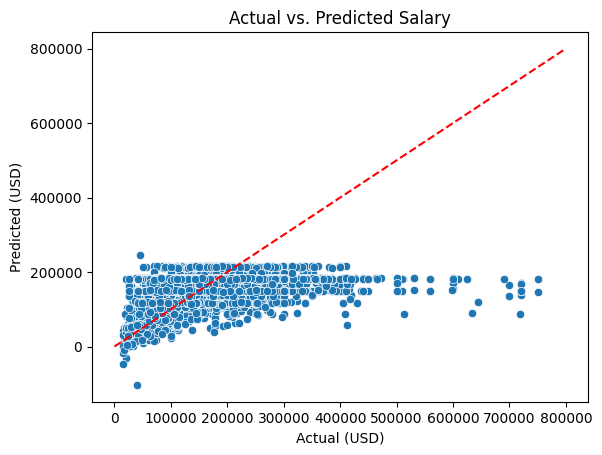

In [27]:
prediction_col = 'salary_in_usd'

X = df.drop(columns=[prediction_col])
y = df[prediction_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Coefficients: {model.coef_.tolist()}")
print(f"Intercept: {model.intercept_}")

plot = sns.scatterplot(x=y_test, y=y_pred)
vals = range(0,800000,1000)
plt.plot(vals, vals, color='red', linestyle='--', label='y=x')
plt.title('Actual vs. Predicted Salary')
plt.xlabel('Actual (USD)')
plt.ylabel('Predicted (USD)')
plt.show()

Root Mean Squared Error: 64816.99
Coefficients: [2733.015224410913, 25853.60598690483, -97.01612800922794, 23603.327038541443, 178.10611350332874, 17109.195668938817, -41573.49098053711, 7137.870968990266, -1215.4445387535707, 49034.973381018484, -10559.82946173464, 17187.118197680255, -18576.9295749094, -18855.872512235575, -11306.576429986853, -4884.912609402267, -21357.946939922804, -19336.257059616815, 16477.21535973902, 10407.699816648434, -27811.821129705648, -67890.02556626628, 52542.76016066535, 16105.870663545371, 13745.355520824185, 625.8780944958926, -27421.65503905232, -23580.410203482206, -16.115654920351517, 19592.59930573032, 25306.439287782774, -22718.425283756394, 36538.6807696286, -20415.16305473089, -22132.853979671763, -22132.85397967267, 22745.46661204305, 5739.57206058723, -15512.408908234254, -208592.0282972276, -44269.84678397687, 85918.43403104242, -56977.80265034237, -28187.274633363413, -3182.304345755521, -7278.2395115711, 10790.981311056677, 57271.617034871

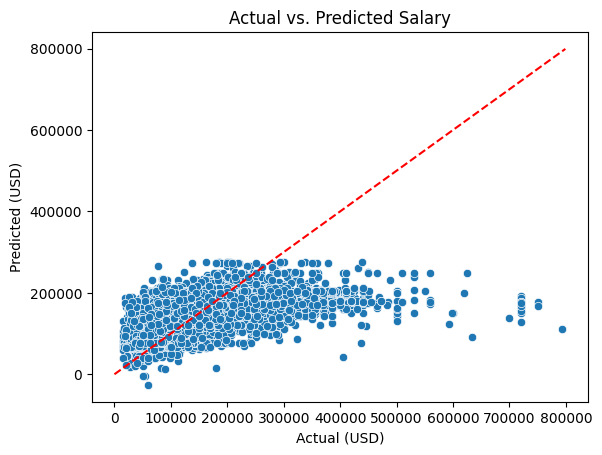

In [28]:
prediction_col = 'salary_in_usd'

X = df_synthetic.drop(columns=[prediction_col])
y = df_synthetic[prediction_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Coefficients: {model.coef_.tolist()}")
print(f"Intercept: {model.intercept_}")

plot = sns.scatterplot(x=y_test, y=y_pred)
vals = range(0,800000,1000)
plt.plot(vals, vals, color='red', linestyle='--', label='y=x')
plt.title('Actual vs. Predicted Salary')
plt.xlabel('Actual (USD)')
plt.ylabel('Predicted (USD)')
plt.show()

In [29]:
selector = SelectKBest(score_func=f_classif, k=50)
X_new = selector.fit_transform(X, y)

# Get selected column names
selected_columns = X.columns[selector.get_support()]

c:\Users\HENSLEYAS21\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Mean Squared Error: 65635.31
work_year                2030.82
experience_level         25905.90
remote_ratio             -109.57
company_size             23225.19
keyword_computational    -26446.22
keyword_sas              -15699.31
keyword_genai            8659.67
keyword_postdoctoral     -67994.12
keyword_management       -6236.79
keyword_data             -28503.36
keyword_machine          -101296.67
keyword_learning         113202.82
keyword_integrity        6413.95
keyword_nlp              -48683.66
keyword_scientist        24540.41
keyword_head             53686.93
keyword_deep             -133640.76
keyword_encounter        -1506.88
keyword_insight          -27672.16
keyword_associate        -26064.49
keyword_scala            -46996.29
keyword_spark            -46996.29
keyword_master           -18399.96
keyword_and              29619.55
keyword_finance          -21214.49
keyword_programmer       -24749.94
keyword_professional     -44034.63
keyword_fellow           5456.51
keywor

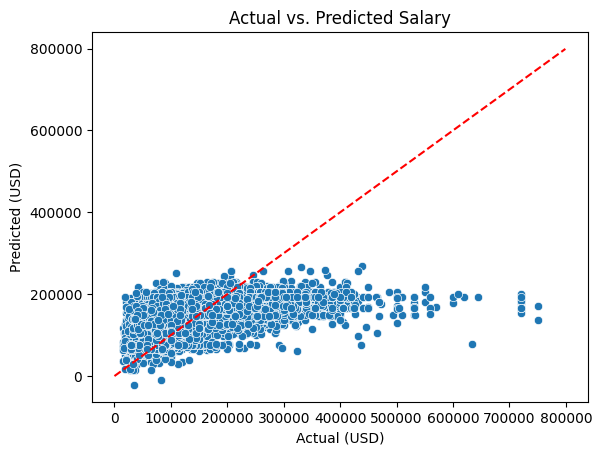

In [ ]:
prediction_col = 'salary_in_usd'

X = df_synthetic[selected_columns]
y = df_synthetic[prediction_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
for i in range(len(selected_columns)):
    print(f"{selected_columns[i].ljust(24)} {model.coef_.tolist()[i]:.2f}")
#print(f"Coefficients: {model.coef_.tolist()}")
print(f"Intercept: {model.intercept_}")

plot = sns.scatterplot(x=y_test, y=y_pred)
vals = range(0,800000,1000)
plt.plot(vals, vals, color='red', linestyle='--', label='y=x')
plt.title('Actual vs. Predicted Salary')
plt.xlabel('Actual (USD)')
plt.ylabel('Predicted (USD)')
plt.show()